# Gaussian Process Regression

At times you don't care about the underlying model for your data points and just want a model that describes the data.  One such fitting technique is know as Gaussian process regression (also know as kriging).  This kind of regression assumes all the data points are drawn from a common covariance function.  This function is used to generate an (infinite) set of functions and only keeps the ones that pass through the observed data.

## Packages being used
+ `tinygp`: has a Gaussian process regression function
+ `numpyro`: used to fit the GP

## Relevant documentation
+ `tinygp`: https://tinygp.readthedocs.io/en/stable/tutorials/modeling.html#modeling-numpyro
+ Use of GPs in astro: https://arxiv.org/abs/2209.08940
+ The textbook on the subject: https://gaussianprocess.org/gpml/

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
import numpyro.infer as infer
import arviz
import mpl_style

from tinygp import kernels, GaussianProcess
from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use(mpl_style.style1)

jax.config.update("jax_enable_x64", True)
numpyro.enable_x64()
numpyro.set_host_device_count(4)


## The squared exponential covariance (or Radial-basis function or Exponential Quadratic)
As an example we will use the squared exponential covariance function:
$$ \operatorname{Cov}{(x_1, x_2; h)} = \exp{\left( \frac{-(x_1 - x_2)^2}{2h^2} \right)} $$
Lets using this function to draw some _unconstrained_ functions:

In [3]:
# Set a random seed
rng_key = jax.random.PRNGKey(0)


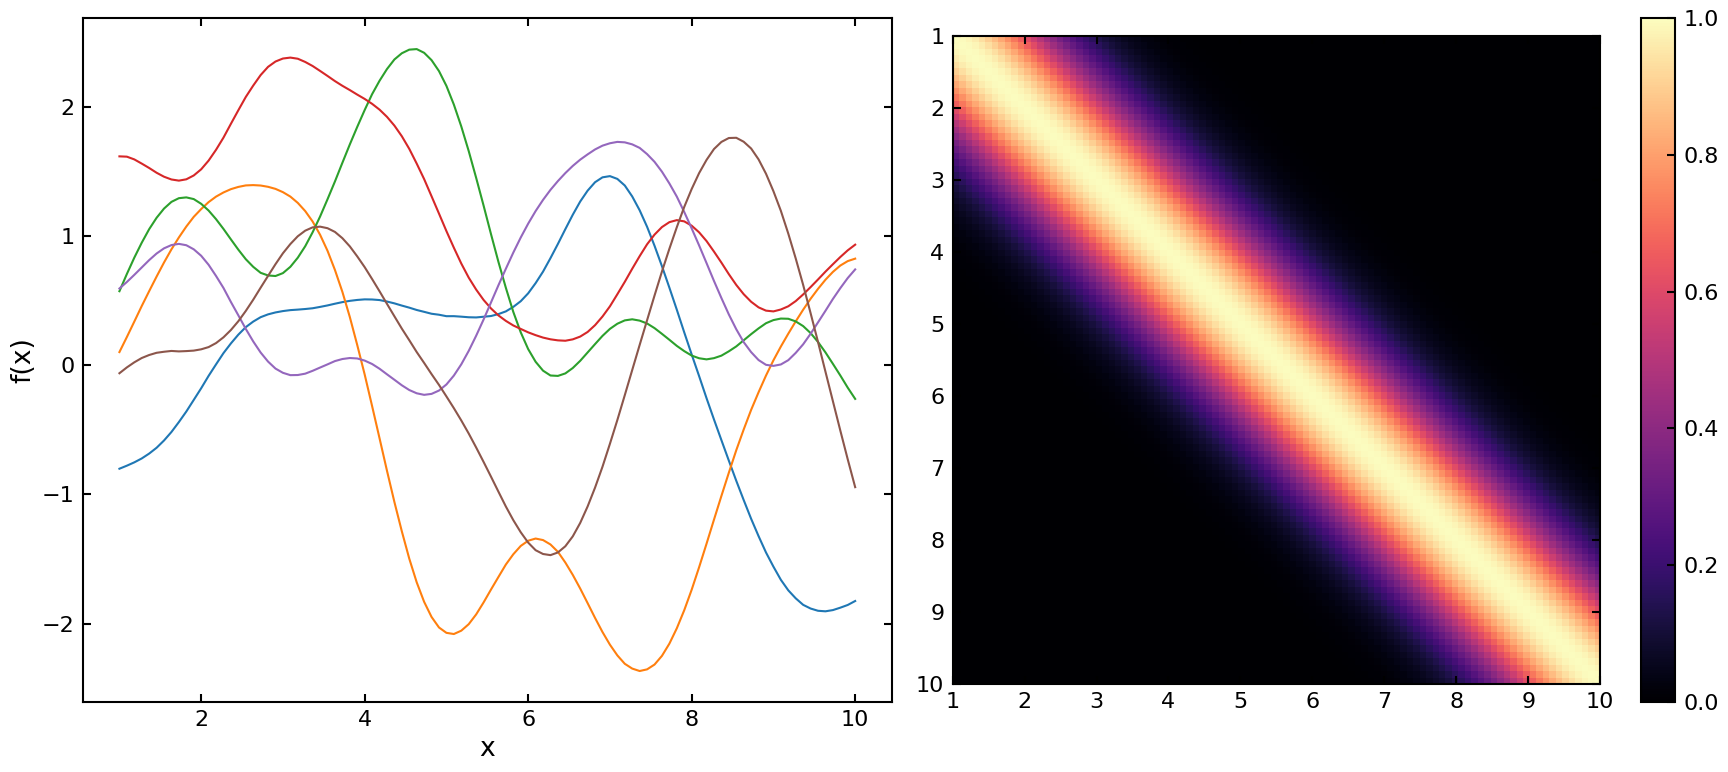

In [4]:
h = 1

x = jnp.linspace(1, 10, 100)[:, None]
K = kernels.ExpSquared(scale=h)
gp = GaussianProcess(K, x, diag=1e-6)

# Rotate the random seed
rng_key, rng_key_ = jax.random.split(rng_key)

draws = gp.sample(rng_key_, shape=(6,))

plt.figure(1, figsize=(18, 8))

plt.subplot(121)
plt.plot(x, draws.T)
plt.xlabel('x')
plt.ylabel('f(x)')

plt.subplot(122)
plt.imshow(K(x, x), interpolation='none', origin='upper', extent=[1, 10, 10, 1])
plt.colorbar()
plt.tight_layout();


## Constrain the model

Assume we have some data points, we can use Gaussian process regression to only pick the models that pass through those points:

In [5]:
x1 = jnp.array([1, 3, 5, 6, 7, 8])
y1 = x1 * jnp.sin(x1)

n_new = 100
x_new = np.linspace(0, 10, n_new)
y_true = x_new * np.sin(x_new)


### With a fixed `h`

Let's use `tinygp` to constrain the kernel from above on the observed data.

In [6]:
K = kernels.ExpSquared(scale=h)
gp = GaussianProcess(K, x1, diag=1e-6)

condition = gp.condition(y1, x_new)

condition_loc = condition.gp.loc
condition_std = np.sqrt(condition.gp.variance)
condition_draws = condition.gp.sample(rng_key_, shape=(20,))


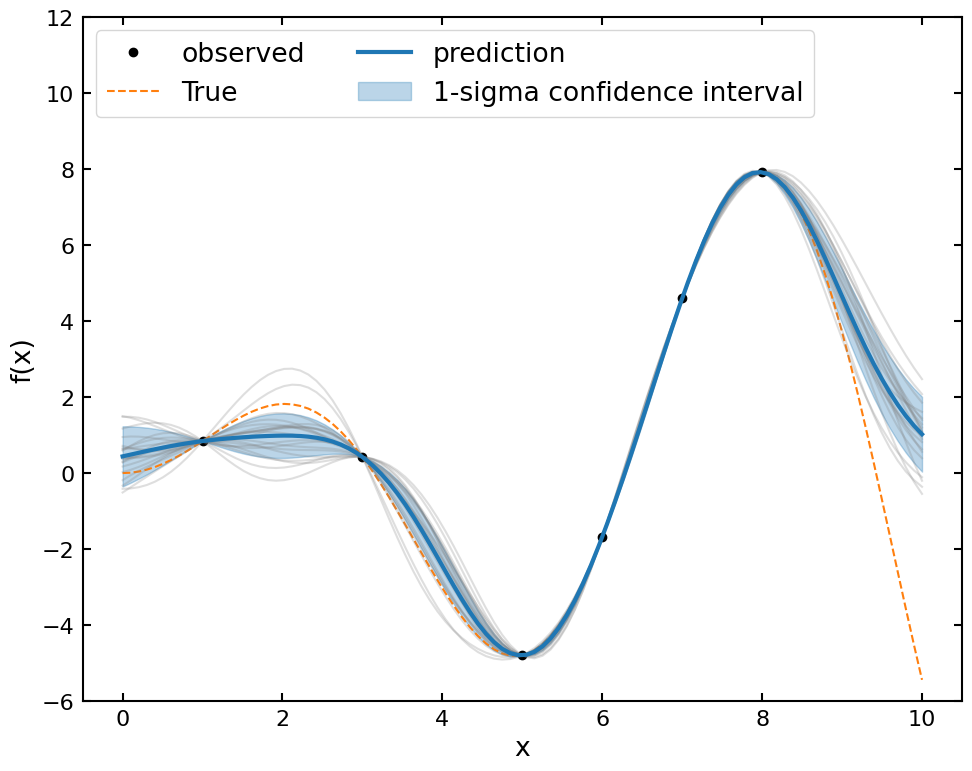

In [7]:
plt.figure(2, figsize=(10, 8))
plt.plot(x1, y1, 'ok', label='observed')

plt.plot(
    x_new,
    y_true,
    '--',
    color='C1',
    label='True'
)

plt.plot(
    x_new,
    condition_loc,
    color='C0',
    lw=3,
    zorder=3,
    label='prediction'
)

# plot 95% best fit region
plt.fill_between(
    x_new,
    condition_loc - condition_std,
    condition_loc + condition_std,
    color='C0',
    alpha=0.3,
    zorder=1,
    label='1-sigma confidence interval'
)

plt.plot(
    x_new,
    condition_draws.T,
    alpha=0.25,
    color='C7'
);

# labels and legend
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-6, 12)
plt.legend(loc='upper left', ncol=2)
plt.tight_layout();


### Fit for `h` with Numpyro

We will define priors for the length scale `h` and the leading scaling coefficient `c`.  We will assume there is a small level of equal but unknown noise associated with each data point.

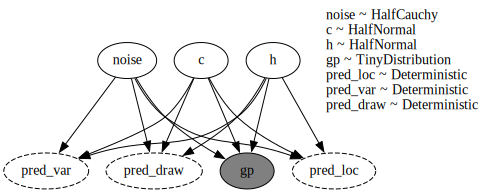

In [61]:
def model(x, y, x_new=None):
    noise = numpyro.sample('noise', dist.HalfCauchy(0.001))
    c = numpyro.sample('c', dist.HalfNormal(5.0))
    h = numpyro.sample('h', dist.HalfNormal(1.0))

    K = c**2 * kernels.ExpSquared(scale=h)
    gp = GaussianProcess(K, x, diag=noise)
    numpyro.sample('gp', gp.numpyro_dist(), obs=y)

    # Optionally condition the GP on new data points and save
    # the mean and variance (used for plotting the results)
    if x_new is not None:
        condition = gp.condition(y, x_new)
        numpyro.deterministic('pred_loc', condition.gp.loc)
        numpyro.deterministic('pred_var', condition.gp.variance)
        numpyro.deterministic('pred_draw', condition.gp.sample(rng_key_, shape=(100,)))

numpyro.render_model(model, model_args=(x1, y1), model_kwargs={'x_new': x_new}, render_distributions=True)


In [62]:
# Rotate the random seed
rng_key, rng_key_ = jax.random.split(rng_key)

init_strategy = infer.init_to_median()
kernel = infer.NUTS(
    model,
    init_strategy=init_strategy,
    target_accept_prob=0.9,
    dense_mass=True
)
mcmc = infer.MCMC(
    kernel,
    num_warmup=2000,
    num_samples=2000,
    num_chains=4,
    progress_bar=True
)
mcmc.run(rng_key_, x1, y1, x_new)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

divergences: 0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c,4.856,1.580,2.506,7.909,0.028,0.021,3365.0,3616.0,1.0
h,1.226,0.489,0.217,2.033,0.014,0.010,1411.0,1075.0,1.0
noise,0.005,0.078,0.000,0.010,0.001,0.001,3564.0,2893.0,1.0


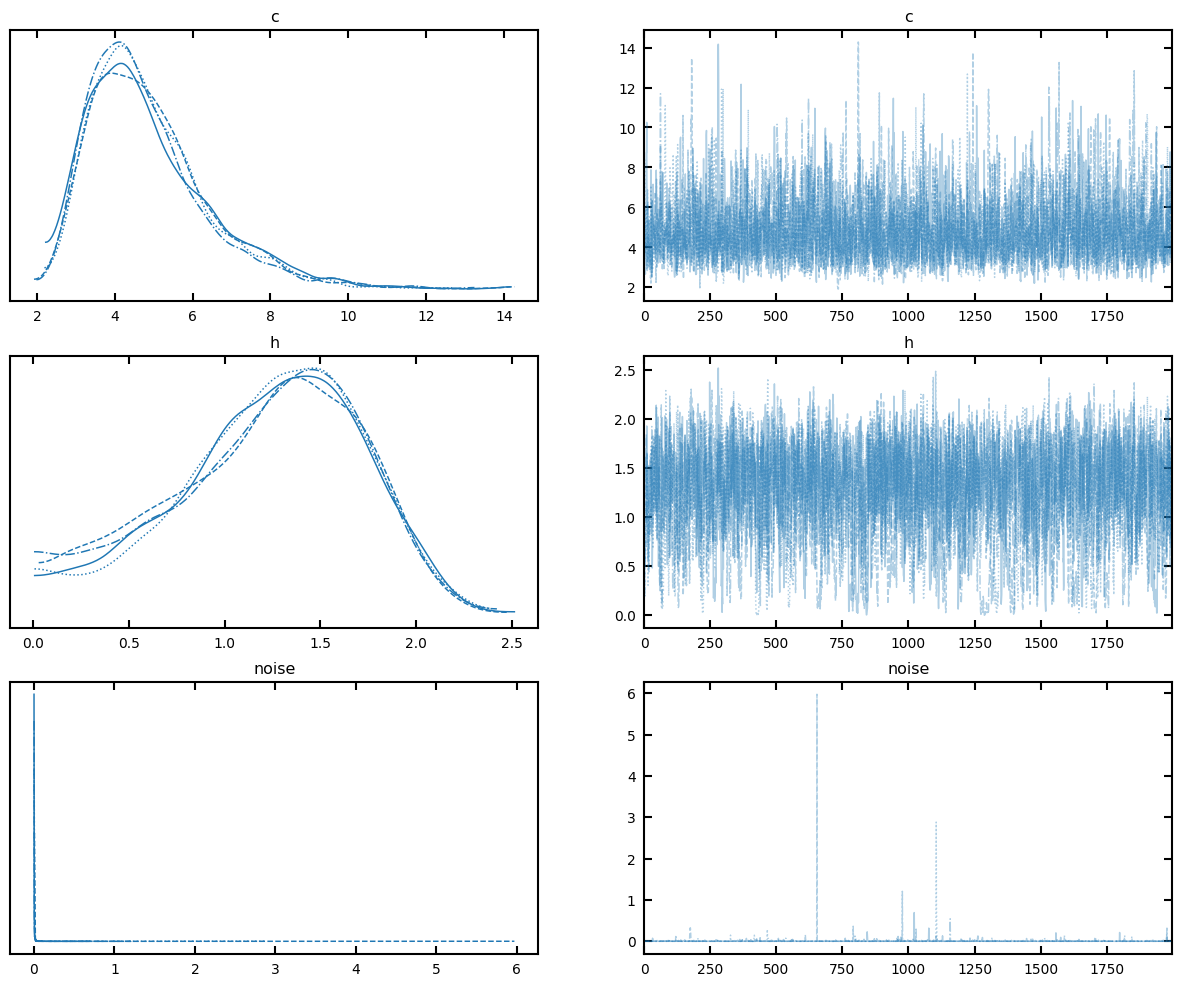

In [63]:
traces = arviz.from_numpyro(mcmc)

print(f'divergences: {traces.sample_stats.diverging.values.sum()}')
display(arviz.summary(traces, var_names=['c', 'h', 'noise']))

arviz.plot_trace(
    traces,
    figsize=(15, 12),
    var_names=['c', 'h', 'noise']
);


(0.0, 0.75)

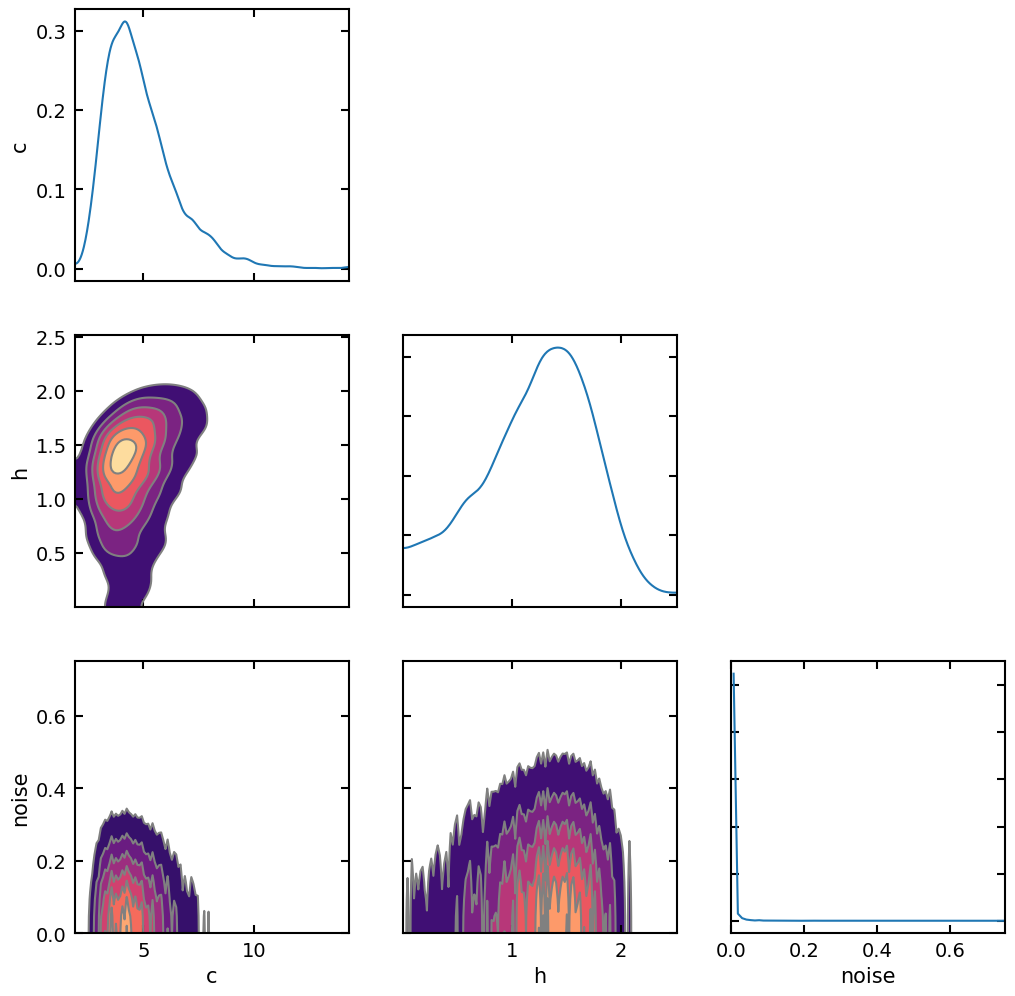

In [66]:
ax = arviz.plot_pair(
    traces,
    marginals=True,
    kind='kde',
    figsize=[12, 12],
    var_names=['c', 'h', 'noise']
)
ax[2][0].set_ylim(0, 0.75)
ax[2][1].set_ylim(0, 0.75)
ax[2][2].set_xlim(0, 0.75)


Notice the trade off between the noise level and the `c` parameter.  When `c` becomes small the noise becomes large, i.e. it models all the points as coming from a flat line with high noise.

Let's plot the result:

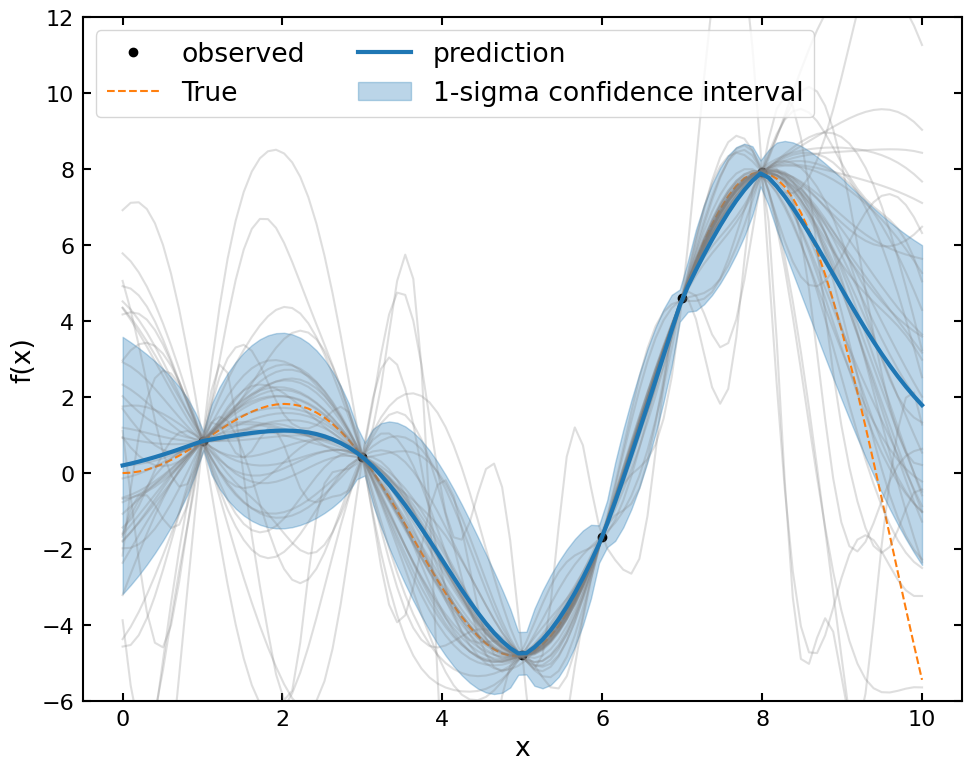

In [69]:
pred_loc = traces.posterior.pred_loc.mean(dim=['chain', 'draw']).data
pred_std = np.sqrt(traces.posterior.pred_var.mean(dim=['chain', 'draw']).data)
pred_draw = traces.posterior.pred_draw.data.reshape(-1, x_new.shape[0])

rng_key, rng_key_ = jax.random.split(rng_key)
idx = jax.random.randint(rng_key_, shape=(20,), minval=0, maxval=len(pred_draw))

plt.figure(2, figsize=(10, 8))
plt.plot(x1, y1, 'ok', label='observed')

plt.plot(
    x_new,
    y_true,
    '--',
    color='C1',
    label='True'
)

plt.plot(
    x_new,
    pred_loc,
    color='C0',
    lw=3,
    zorder=3,
    label='prediction'
)

# plot 95% best fit region
plt.fill_between(
    x_new,
    pred_loc - pred_std,
    pred_loc + pred_std,
    color='C0',
    alpha=0.3,
    zorder=1,
    label='1-sigma confidence interval'
)

plt.plot(
    x_new,
    pred_draw[idx].T,
    alpha=0.25,
    color='C7'
);

# labels and legend
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-6, 12)
plt.legend(loc='upper left', ncol=2)
plt.tight_layout();


## Noisy data
Let's add some noise to the data.  We will assume each data point has independent errorbars.  These values can be added to the constant noise we fit for in the previous model.  NOTE: `diag` takes the values to add to the diagonal of the covariance matrix, so we need to square the errorbars before passing them in.

In [70]:
y_err = 0.5 + np.random.random(y1.shape)
y_noise = np.random.normal(0, y_err)
y2 = y1 + y_noise


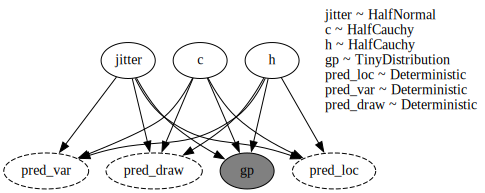

In [209]:
def model_noise(x, y, y_err, x_new=None):
    jitter = numpyro.sample('jitter', dist.HalfNormal(0.001))
    noise = y_err**2 + jitter

    c = numpyro.sample('c', dist.HalfCauchy(10.0))
    h = numpyro.sample('h', dist.HalfCauchy(1.0))

    K = c**2 * kernels.ExpSquared(scale=h)
    gp = GaussianProcess(K, x, diag=noise)
    numpyro.sample('gp', gp.numpyro_dist(), obs=y)
    # Optionally condition the GP on new data points and save
    # the mean and variance (used for plotting the results)
    if x_new is not None:
        condition = gp.condition(y, x_new)
        numpyro.deterministic('pred_loc', condition.gp.loc)
        numpyro.deterministic('pred_var', condition.gp.variance)
        numpyro.deterministic('pred_draw', condition.gp.sample(rng_key_, shape=(100,)))

numpyro.render_model(model_noise, model_args=(x1, y2, y_err), model_kwargs={'x_new': x_new}, render_distributions=True)


In [210]:
# Rotate the random seed
rng_key, rng_key_ = jax.random.split(rng_key)

init_strategy = infer.init_to_median()
kernel = infer.NUTS(
    model_noise,
    init_strategy=init_strategy,
    target_accept_prob=0.9,
    dense_mass=True
)
mcmc = infer.MCMC(
    kernel,
    num_warmup=2000,
    num_samples=2000,
    num_chains=4,
    progress_bar=True
)
mcmc.run(rng_key_, x1, y2, y_err, x_new)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

divergences: 0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c,4.514,2.423,1.598,8.665,0.049,0.035,3187.0,2858.0,1.0
h,1.189,0.683,0.000,2.297,0.015,0.011,1773.0,1686.0,1.0
jitter,0.001,0.001,0.000,0.002,0.000,0.000,2062.0,1451.0,1.0


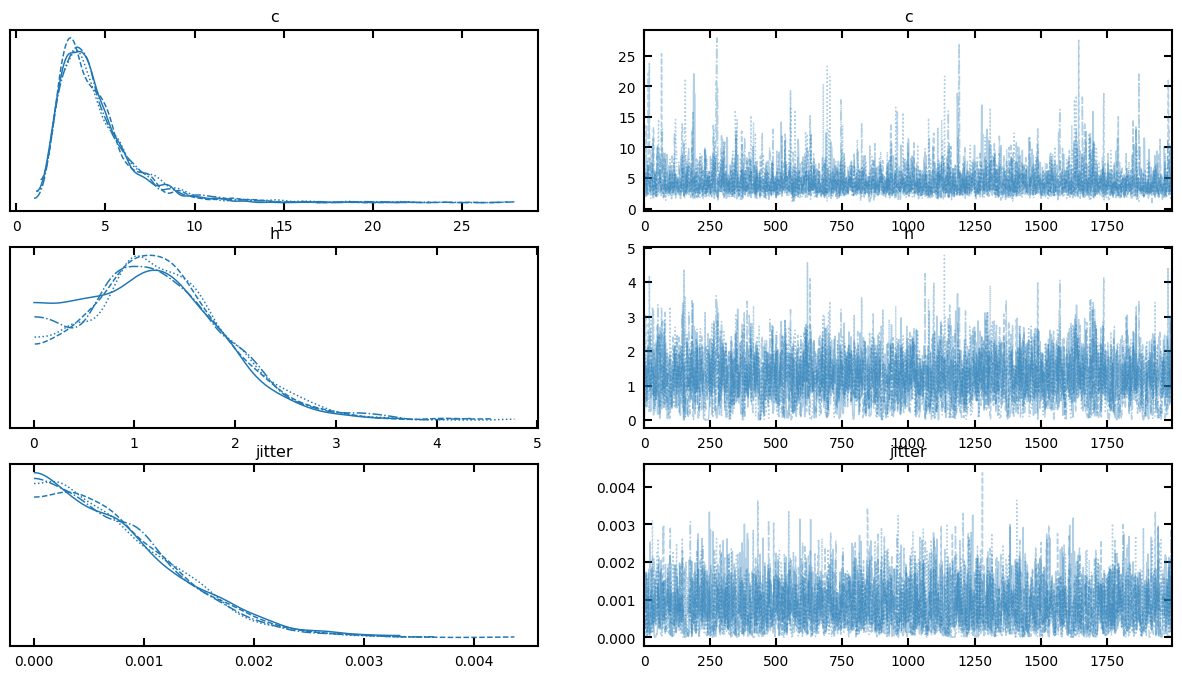

In [211]:
traces_noise = arviz.from_numpyro(mcmc)

print(f'divergences: {traces_noise.sample_stats.diverging.values.sum()}')
display(arviz.summary(traces_noise, var_names=['c', 'h', 'jitter']))

arviz.plot_trace(
    traces_noise,
    figsize=(15, 8),
    var_names=['c', 'h', 'jitter']
);


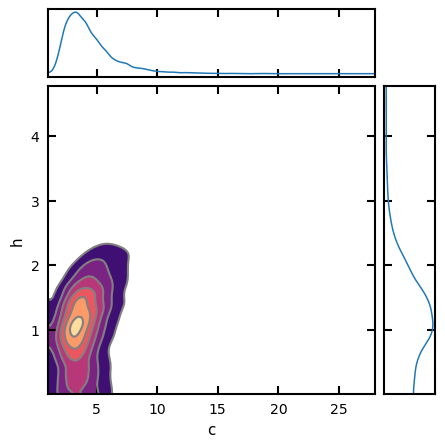

In [212]:
ax = arviz.plot_pair(
    traces_noise,
    marginals=True,
    kind='kde',
    figsize=[5, 5],
    var_names=['c', 'h']
)


### Plot the results
As before we can interpolate and extrapolate to new points.

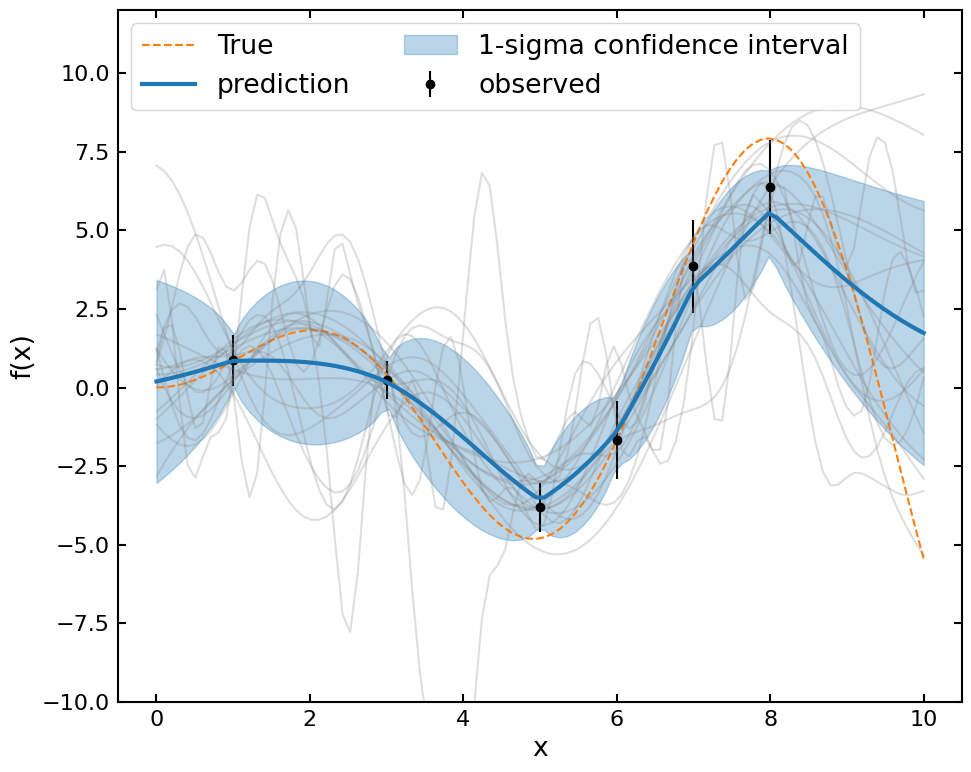

In [213]:
pred_loc = traces_noise.posterior.pred_loc.mean(dim=['chain', 'draw']).data
pred_std = np.sqrt(traces_noise.posterior.pred_var.mean(dim=['chain', 'draw']).data)
pred_draw = traces_noise.posterior.pred_draw.data.reshape(-1, x_new.shape[0])

rng_key, rng_key_ = jax.random.split(rng_key)
idx = jax.random.randint(rng_key_, shape=(20,), minval=0, maxval=len(pred_draw))

plt.figure(4, figsize=(10, 8))
plt.errorbar(x1, y2, yerr=y_err, fmt='ok', label='observed')

plt.plot(
    x_new,
    y_true,
    '--',
    color='C1',
    label='True'
)

plt.plot(
    x_new,
    pred_loc,
    color='C0',
    lw=3,
    zorder=3,
    label='prediction'
)

# plot 95% best fit region
plt.fill_between(
    x_new,
    pred_loc - pred_std,
    pred_loc + pred_std,
    color='C0',
    alpha=0.3,
    zorder=1,
    label='1-sigma confidence interval'
)

plt.plot(
    x_new,
    pred_draw[idx].T,
    alpha=0.25,
    color='C7'
)

# labels and legend
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-10, 12)
plt.legend(loc='upper left', ncol=2)
plt.tight_layout();


For comparison lets look at the MAP solution (e.g. take the median of the `h`, `c`, and `jitter` values).

In [214]:
h = traces_noise.posterior.h.median(dim=['chain', 'draw']).data
c = traces_noise.posterior.c.median(dim=['chain', 'draw']).data
jitter = traces_noise.posterior.jitter.median(dim=['chain', 'draw']).data

gp = GaussianProcess(K, x1, diag=y_err**2 + jitter)
condition = gp.condition(y2, x_new)

pred_loc = condition.gp.loc
pred_std = np.sqrt(condition.gp.variance)
pred_draw = condition.gp.sample(rng_key_, shape=(20,))


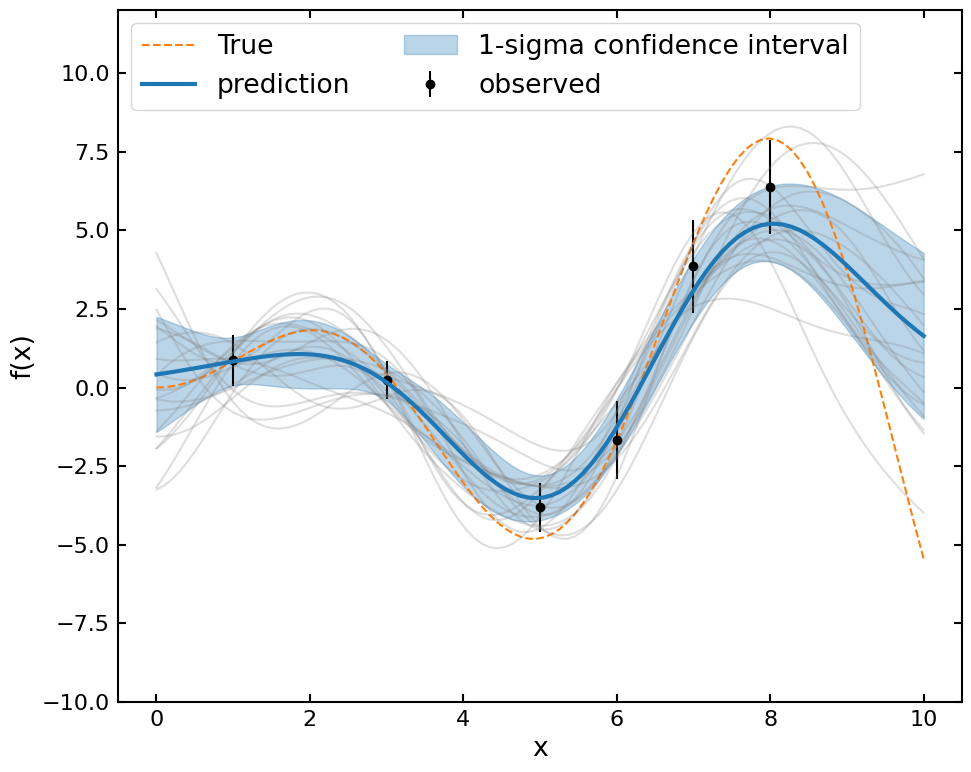

In [215]:
plt.figure(5, figsize=(10, 8))
plt.errorbar(x1, y2, yerr=y_err, fmt='ok', label='observed')

plt.plot(
    x_new,
    y_true,
    '--',
    color='C1',
    label='True'
)

plt.plot(
    x_new,
    pred_loc,
    color='C0',
    lw=3,
    zorder=3,
    label='prediction'
)

# plot 95% best fit region
plt.fill_between(
    x_new,
    pred_loc - pred_std,
    pred_loc + pred_std,
    color='C0',
    alpha=0.3,
    zorder=1,
    label='1-sigma confidence interval'
)

plt.plot(
    x_new,
    pred_draw.T,
    alpha=0.25,
    color='C7'
)

# labels and legend
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-10, 12)
plt.legend(loc='upper left', ncol=2)
plt.tight_layout();


## Other notes
+ There are many covariance kernels you can pick;
    + `Constant`: a constant value that can be multiplied or added to any of the other kernels
    + `ExpSquared`: exponentiated quadratic, smooth kernel parameterized by a length-scale
    + `RationalQuadratic`: rational quadratic, a (infinite sum) mixture of different `ExpQud`'s each with different length-scales
    + `Exp`: Similar to `ExpSquared` but without the square in the exponent.
    + `Marten52`: Marten 5/2 non-smooth generalization of `RBF`, parameterized by length-scale and smoothness
    + `Marten32`: Marten 3/2 non-smooth generalization of `RBF`, parameterized by length-scale and smoothness
    + `Cosine`: periodic kernel built with `cos`
    + `Periodic`: periodic function kernel, parameterized by a length-scale and periodicity

+ All `X` positions must be unique
+ The computational complexity is $O(N^3)$ where $N$ is the number of data point.  If you have a large number of data points you can use Numpyro's variational inference methods that replace the posterior with simpler approximations that are faster to compute.